In [1]:

import torch
import torch
from torch.utils.data import DataLoader
import pandas as pd
import glob

import segmentation_models_pytorch as smp

import lightning as L
from lightning.pytorch import Trainer, seed_everything
from lightning.pytorch.loggers import WandbLogger

from lightning_module import LitUNetPlusPlus
from config import Config
from dataset import *
from utils import plot_img_label_pred
from transforms import ImageVisualizer
import wandb
import seaborn as sns

import monai
from monai.transforms import *

from tabulate import tabulate
import matplotlib.pyplot as plt

seed_everything(99, workers=True)

from lightning.pytorch.plugins.environments import SLURMEnvironment
SLURMEnvironment.detect = lambda: False


INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.8 (you have 1.4.7). Upgrade using: pip install --upgrade albumentations
[rank: 0] Seed set to 99


In [2]:
cfg = Config(experiment_name = "Cirrus")

In [5]:
experiment_folder = Path("/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/") / cfg.experiment_name
checkpoint = list(experiment_folder.glob("*.ckpt"))[0]
checkpoint

PosixPath('/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Cirrus/self.experiment_name=0-epoch=64-val_loss_total=0.230-val_precision=0.879.ckpt')

## Run experiments

* Baseline
    - Untrained
    - Fully supervised

* Domain Adaptation
    - Spectralis without SVDNA
    - Topcon without SVDNA
    - Cirrus without SVDNA
    - Spectralis with SVDNA
    - Topcon with SVDNA
    - Cirrus with SVDNA

    Take average of experiments without SVDNA and with SVDNA

* Ablation
    - Spectralis with SVDNA
    - Spectralis only SVDNA (no Histogram matching)
    - Spectralis only Histogram matching (no SVDNA)

In [ ]:
def run_experiment(
        source_domains, 
        experiment_name,
        batch_size=8,
        cfg=cfg):
    
    # DEFINE EXPERIMENT PARAMETERS
    ####################################################################################
    cfg.source_domains = source_domains


    cfg.experiment_name = experiment_name
    # experiment name defines the names for:
        # - the model
        # - the results file
        # - the wandb run
    ####################################################################################


    cfg.batch_size = batch_size
    cfg.epochs = 150

    # OCTDatasetPrep is a class that performs all necessary sorting and filtering of the dataset
    ds = OCTDatasetPrep(cfg.train_dir, source_domains = cfg.source_domains)

    # .get_datasets method handles splitting and which test set to use (a custom one that is split from
    # the training set, or the official challenge testset)
    train_data, val_data, test_data = ds.get_datasets(dataset_split=[0.8, 0.2], use_official_testset=True)

    # MakeDataset is a class that handles the actual dataset creation, including transforms
    train_dataset = MakeDataset(train_data, cfg.train_transforms)
    val_dataset = MakeDataset(val_data, cfg.val_transforms)
    test_dataset = MakeDataset(test_data, cfg.test_transforms)

    train_loader = DataLoader(train_dataset, batch_size=cfg.batch_size, shuffle=True, num_workers=7, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)


    wandb_logger = WandbLogger(project="PracticalWorkinAI", 
                            name=cfg.experiment_name)


    # model is the actual model from segmentation_models_pytorch
    model = smp.UnetPlusPlus(**cfg.model_parameters_unetpp)

    # LitUnetPlusPlus is the lightning module defined in lightning_module.py
    unetpp = LitUNetPlusPlus(cfg, model, experiment_name=cfg.experiment_name)

    trainer = L.Trainer(max_epochs=cfg.epochs,
                        logger=wandb_logger,
                        default_root_dir=Path(cfg.default_root_dir),
                        log_every_n_steps=10,
                        deterministic=True,
                        callbacks=[cfg.checkpoint_callback, # saves best model based on validation loss, every 5 epochs
                                  cfg.lr_monitor, 
                                  #cfg.save_initial_model,
                                  cfg.early_stopping, # stops training if validation loss does not improve for 20 epochs
                                  cfg.aggregate_testing_results])


    trainer.fit(unetpp, train_dataloaders=train_loader, val_dataloaders=val_loader)
    trainer.test(unetpp, dataloaders=test_loader)
    wandb.finish


In [ ]:
cfg.experiments = [
    {
        "source_domains": ["Spectralis", "Topcon", "Cirrus"],
        "experiment_name": "FullySupervised"
    },
    {
        "source_domains": ["Spectralis"],
        "experiment_name": "Spectralis"
    },
    {
        "source_domains": ["Topcon"],
        "experiment_name": "Topcon"
    },
    {
        "source_domains": ["Cirrus"],
        "experiment_name": "Cirrus"
    },
    {
        "source_domains": ["Spectralis", "Topcon"],
        "experiment_name": "SpectralisTopcon"
    }
]

for experiment in cfg.experiments:
    run_experiment(experiment["source_domains"], experiment["experiment_name"])

In [5]:
experiments = glob.glob(f"{cfg.model_path}/*")
experiments

['/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Supervised',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Spectralis-Topcon',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Spectralis-Cirrus',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Topcon-Cirrus',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Spectralis-Topcon-noSVDNA',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Spectralis-Cirrus-noSVDNA',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Topcon-Cirrus-noSVDNA',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Spectralis',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Topcon',
 '/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Cirrus']

### Test all models on the test set

In [ ]:
# OCTDatasetPrep is a class that performs all necessary sorting and filtering of the dataset
ds = OCTDatasetPrep(cfg.train_dir, source_domains = cfg.source_domains)

# .get_datasets method handles splitting and which test set to use (a custom one that is split from
# the training set, or the official challenge testset)
_, _, test_data = ds.get_datasets(dataset_split=[0.8, 0.2], use_official_testset=True)

# MakeDataset is a class that handles the actual dataset creation, including transforms
test_dataset = MakeDataset(test_data, cfg.test_transforms)

test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)

In [7]:
test_all_models = True

if test_all_models:
    
    # find all folders with checkpoints
    experiments = [os.path.basename(exp) for exp in glob.glob(f"{cfg.model_path}/*")]

    for exp in experiments:
        
        checkpoint = list(Path(cfg.model_path / exp).glob("*.ckpt"))[0]

        wandb_logger = WandbLogger(project="PracticalWorkinAI", group="Testing", name=exp)

        model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = checkpoint, experiment_name=exp)
    
        trainer = L.Trainer(max_epochs=cfg.epochs,
                            logger=wandb_logger,
                            default_root_dir=Path(cfg.default_root_dir),
                            log_every_n_steps=10,
                            callbacks=[cfg.checkpoint_callback, # saves best model based on validation loss, every 5 epochs
                                       cfg.lr_monitor, 
                                       cfg.aggregate_testing_results],
                            deterministic=True)
        
        test_loader = DataLoader(test_dataset, batch_size=cfg.batch_size, shuffle=False, num_workers=7, persistent_workers=True)
        
        trainer.test(model, dataloaders=test_loader)
        wandb.finish()

/home/optima/mhaderer/OPTIMA_Masterarbeit/practical/models/Supervised/self.experiment_name=0-epoch=84-val_loss_total=0.247-val_precision=0.874.ckpt


## Visualization and results

#### Load model and make predictions on random images from validation set

In [7]:
experiments = [os.path.basename(exp) for exp in glob.glob(f"{cfg.model_path}/*")]
experiments

['spectralis-no-svdna-epoch=139-val_loss_total=0.302-val_precision=0.851.ckpt',
 'supervised-epoch=134-val_loss_total=0.26-val_precision=0.85.ckpt',
 'initial_model.ckpt',
 'spectr-epoch=139-val_loss_total=0.29-val_precision=0.84.ckpt']

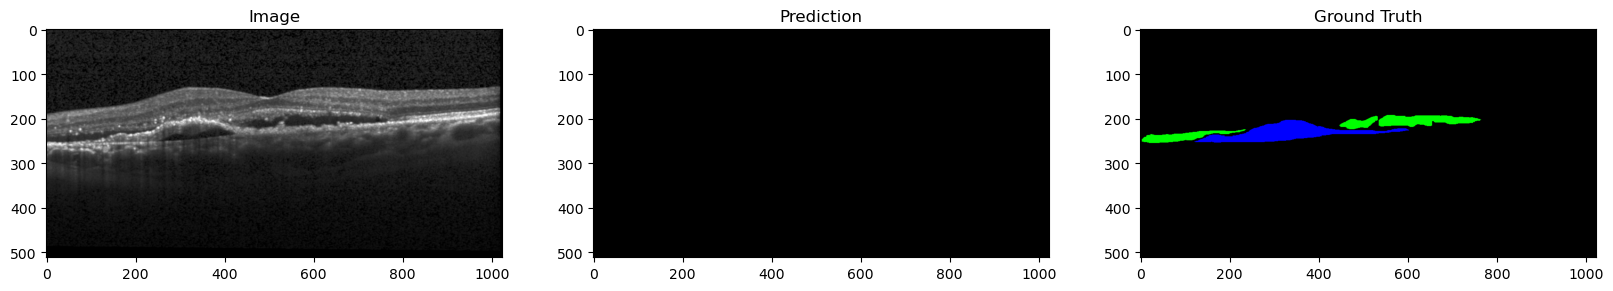

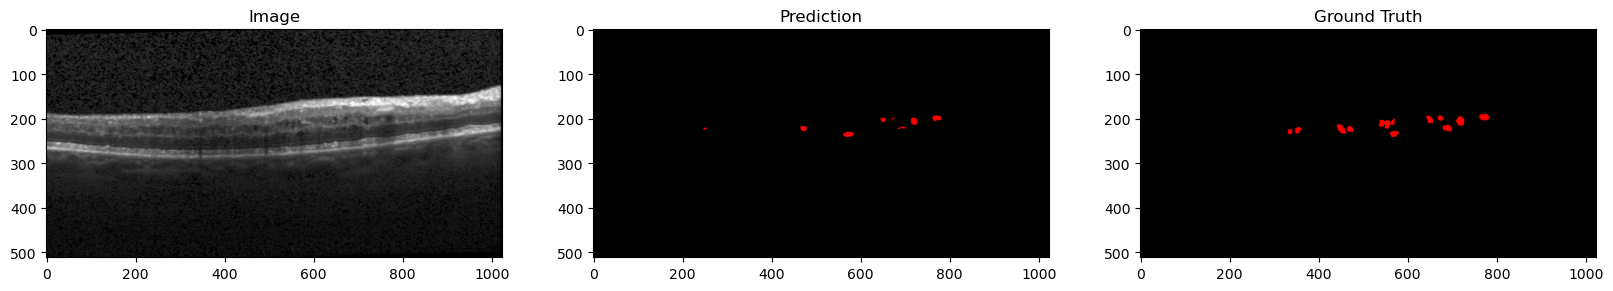

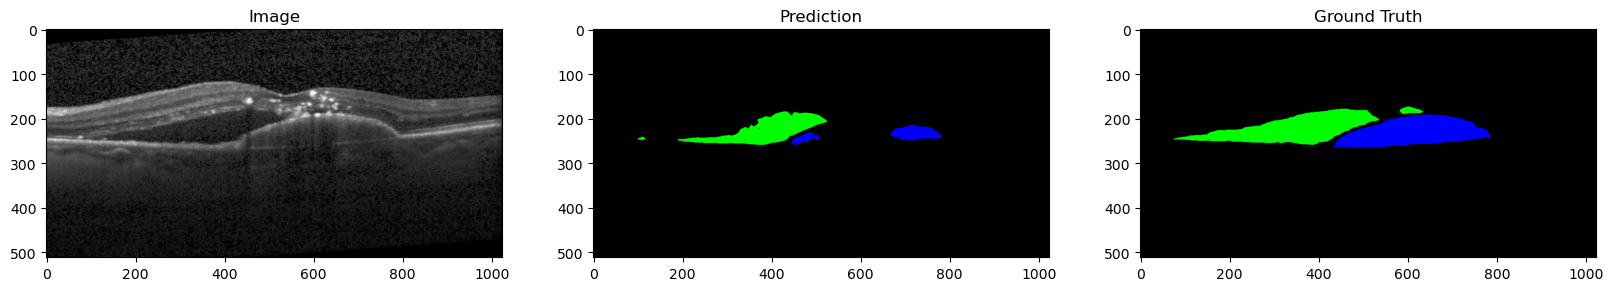

In [33]:
get_predictions = True

experiment_for_prediction = "cirrus_only_histmatching"
with torch.no_grad():
    if get_predictions:

        checkpoint = str(list(Path(cfg.model_path / experiment_for_prediction).glob("*.ckpt"))[0])
        model = LitUNetPlusPlus.load_from_checkpoint(checkpoint_path = checkpoint, 
                                                     experiment_name=experiment_for_prediction)
        model.eval()

        for i in range(np.min([3, len(val_dataset)])):
            rand_num = np.random.randint(0, len(val_dataset))
            sample = val_dataset[rand_num]

            img = sample['img'].unsqueeze(0).to(cfg.device)
            mask = sample['masks'].unsqueeze(0).to(cfg.device)

            pred = model(img)
            pred = torch.sigmoid(pred)
            
            # thresholding
            pred[pred > 0.5] = 1
            pred[pred <= 0.5] = 0

            plot_img_label_pred(img, pred, mask)

#### Visualize some images and masks

In [ ]:
print_some_imgs = False

if print_some_imgs:
    
    # ImageVisualizer shows images post-transformation
    transforms_visualize = Compose([cfg.train_transforms, ImageVisualizer(keys=['img', 'label', 'masks'])])
    train_data_raw, _, _ = OCTDatasetPrep(cfg.train_dir, source_domains=cfg.source_domains).get_datasets(use_official_testset=False)
    train_data = MakeDataset(train_data_raw, transforms_visualize)


    for i in range(2):
 
        rand_num = np.random.randint(0, len(train_data))
        sample = train_data[rand_num]
        print(f"Sample {i+1}", 
              "\nImg: ", sample['img'].shape,
              "\nLabel: ", sample['label'].shape,
              "\nMasks: ", sample['masks'].shape)




#### Create results tables from saved csv

In [37]:
ablations = [
    "source_spectralis",
    "spectralis_no-svdna",
    "spectralis_svdna_no_Histmatching",
    "spectralis_only_histmatching"
    ]

mean_normal = [
    "source_spectralis",
    "source_cirrus"
]
mean_nosvdna = [
    "spectralis_no-svdna",
    "cirrus_no_svdna"
]

<Axes: xlabel='Task', ylabel='Recall'>

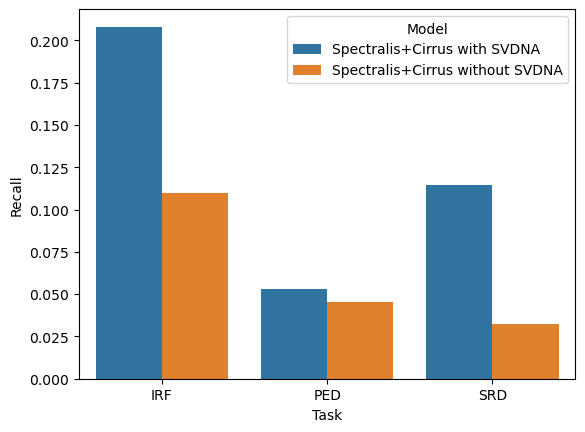

In [64]:

# Get the path to the "results" folder
results_folder = os.path.join(os.getcwd(), "results")

# Get all files in the "results" folder that match the pattern "results_mean_*.csv"
file_list = glob.glob(os.path.join(results_folder, "*/results_*.csv"), recursive=True)

# Load each file into a pandas DataFrame and concatenate them
dfs = []
for file in file_list:
    file_path = os.path.join(results_folder, file)
    df = pd.read_csv(file_path, index_col=0)
    dfs.append(df)

result = pd.concat(dfs)
result.drop(["Dice"], axis=1, inplace=True)


# take mean of those models specified in the list mean_normal
svdna = result[result["Model"].isin(mean_normal)]
svdna.loc[:,"Model"] = "Spectralis+Cirrus with SVDNA"
svdna = svdna.groupby(["Task", "Model"]).mean().reset_index()

# take mean of those models specified in the list mean_nosvdna
no_svdna = result[result["Model"].isin(mean_nosvdna)]
no_svdna.loc[:,"Model"] = "Spectralis+Cirrus without SVDNA"
no_svdna = no_svdna.groupby(["Task", "Model"]).mean().reset_index()





# filter out only the models specified in the list ablation
ablation = result[result["Model"].isin(ablations)]
ablation = ablation[ablation["Task"] != "Background"]
ablation_means = ablation.groupby(["Task", "Model"]).mean().reset_index()
ablation_stds = ablation.groupby(["Task", "Model"]).std().reset_index()

# rename Model entries to be more readable using a dictionary
ablation["Model"] = ablation["Model"].replace({
    "source_spectralis": "Source Spectralis",
    "spectralis_no-svdna": "Spectralis w/o SVDNA",
    "spectralis_svdna_no_Histmatching": "Spectralis w/o Histmatching",
    "spectralis_only_histmatching": "Spectralis Histmatching only"
})

# plot ablation results in bar chart seaborn


#means = result.groupby(["Task", "Model"]).mean().round(3)
#stds = result.groupby(["Task", "Model"]).std().round(3)


# combine the two dataframes such that the result has "mean (std)" format
#result = means.astype(str) + " (" + stds.astype(str) + ")" 

# tabulate
#print(tabulate(result, headers='keys', tablefmt='fancy_grid'))
#result.to_latex("results.tex")


['trial', 'spectralis_tinytest', 'supervised_tinytest']


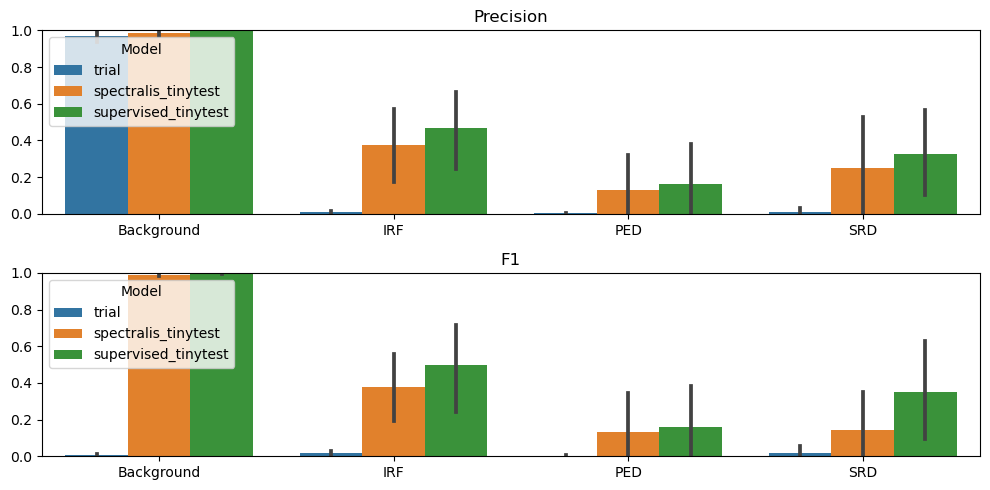

In [ ]:

# Get the path to the "results" folder
results_folder = os.path.join(os.getcwd(), "results")

# Get all files in the "results" folder that match the pattern "results_mean_*.csv"
file_list = [file for file in os.listdir(results_folder) if file.startswith("results_raw_") and file.endswith(".csv")]

# Load each file into a pandas DataFrame and concatenate them
dfs = []
for file in file_list:
    file_path = os.path.join(results_folder, file)
    df = pd.read_csv(file_path, index_col=0)
    dfs.append(df)

result = pd.concat(dfs)


# melt the dataframe
result_melted = pd.melt(result, id_vars=["Model", "Task"], value_vars=["Dice", "Accuracy", "F1", "Precision", "Recall", "Specificity"], var_name="Metric")

# create 2 subplots, one for each metric
fig, axes = plt.subplots(2, 1, figsize=(10, 5))

# Get a sorted list of unique model names, with "trials" first
task_order = sorted(result_melted["Task"].unique())
model_order = sorted(result_melted["Model"].unique())
model_order.insert(0, model_order.pop(model_order.index('trial')))
print(model_order)

# Only plot Precision and F1
for i, metric in enumerate(["Precision", "F1"]):
    data = result_melted[result_melted["Metric"] == metric]
    data = data.sort_values('value', ascending=True)  # sort the data by value

    # Pass the model_order list to the order parameter
    sns.barplot(data=data, x="Task", y="value", hue="Model", ax=axes[i], order=task_order, hue_order=model_order)

    axes[i].set_title(metric)
    axes[i].set_ylim(0, 1)
    axes[i].set_ylabel("")
    axes[i].set_xlabel("")
    axes[i].legend(loc='upper left', title="Model")

plt.tight_layout()
plt.show()